# Polynomial Chaos Expansions

- Change main to return cauchy stresses
- Implement PCES to generate Cauchy stresses in Voigt notation

In [15]:
import numpy as np
import numpoly
from scipy.stats import lognorm, norm, gaussian_kde
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import seaborn as sns
import pickle
import pandas as pd
import chaospy as cp
import json

In [3]:
tex_fonts = {
    # Use LaTeX to write all text
    # "text.usetex": True,
    "font.family": "serif",
    # Use 10pt font in plots, to match 10pt font in document
    "axes.labelsize": 12,
    "font.size": 12,
    # Make the legend/label fonts a little smaller
    "legend.fontsize": 12,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12
}

# update to latex fonts
plt.rcParams.update(tex_fonts)

In [4]:
class PCEConstructor:
    def __init__(self, df: pd.DataFrame, rnd_inputs: dict):
        self.df = df
        self.rnd_inputs = rnd_inputs
    #     self._prepare_data()
        

    # def _prepare_data(self):
    #     try:
    #         self.df = self.df.applymap(lambda x: x.replace('\n', '') if isinstance(x, str) else x)
    #         self.df = self.df.applymap(lambda x: np.fromstring(x.strip('[]'), sep=' ') if isinstance(x, str) else x)
    #     except Exception as e:
    #         raise ValueError(f"Error while preparing data: {e}")
    
    def x(self):
        x_columns = list(self.rnd_inputs.keys())
        return np.array(self.df[x_columns]).T

    def y(self, y_column: str, 
          #array_index: int
          ):
        return np.array(self.df[y_column].tolist())
        # return self.df[y_column].apply(lambda x: x[array_index])
    
    def get_distribution(self, dist: str, args):
        a = args[0]
        b = args[1]
        if len(args) > 2:
            c = args[2]
        if dist in ['uniform', 'Uniform']:
            return cp.Uniform(a, b)
        elif dist in ['normal', 'Normal']:
            return cp.Normal(a, b)
        elif dist in ['lognormal', 'Lognormal', 'LogNormal']:
            return cp.LogNormal(a, b)
        else:
            raise ValueError(f"Unknown distribution: {dist}")
        
    def get_joint_distribution(self):
        joint_dist = cp.J(*[self.get_distribution(props['distribution'], list(props.values())[1:])
                            for props in self.rnd_inputs.values()])
        return joint_dist

    
    def get_pce(self, y_column: str, degree: int, N_fit: int, seed: int = 0):
        np.random.seed(seed)
        x = self.x() # Random inputs
        y = self.y(y_column) # Output column 
        # Distribution of the random inputs
        # joint_dist = cp.J(*[self.get_distribution(props['distribution'], list(props.values())[1:]) 
        #                     for props in self.rnd_inputs.values()])
        joint_dist = self.get_joint_distribution()
        # Create the polynomial basis
        poly_basis, norms = cp.generate_expansion(order=degree, dist=joint_dist, retall=True)
        # Randomly pick N_fit samples from the data
        idx = np.random.choice(x.shape[1], N_fit, replace=False)
        keys = self.df['deformation'][0] 
        pce_dict = {
            keys[i]: cp.fit_regression(poly_basis, x[:, idx], y[idx, i]) for i in range(len(keys))
        }
        return pce_dict #, poly_basis, norms
    

In [16]:
results_dir = '20250328_135456'

# Load data from csv
# df_results_csv = pd.read_csv(f'sim/{results_dir}/results.csv')

# Load results data from pickle
with open(f'sim/{results_dir}/results.pkl', 'rb') as file:
    df_results = pickle.load(file)

# Load random inputs from csv
with open(f'sim/{results_dir}/study_props_info.csv', 'r') as file:
    rnd_inputs = json.load(file)

In [15]:
df_results['stress'][0]

array([[ 4.44089210e-16,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-8.22211729e-03,  4.59125415e-02,  0.00000000e+00,
         1.33961623e-01,  0.00000000e+00,  0.00000000e+00],
       [-1.20407929e-02,  9.85382221e-02,  0.00000000e+00,
         2.83334032e-01,  0.00000000e+00,  0.00000000e+00],
       [-1.04951006e-02,  1.59319269e-01,  0.00000000e+00,
         4.50615540e-01,  0.00000000e+00,  0.00000000e+00],
       [-2.41862629e-03,  2.29957105e-01,  0.00000000e+00,
         6.38744707e-01,  0.00000000e+00,  0.00000000e+00],
       [ 1.35920167e-02,  3.12492038e-01,  0.00000000e+00,
         8.51176810e-01,  0.00000000e+00,  0.00000000e+00],
       [ 3.92402342e-02,  4.09362718e-01,  0.00000000e+00,
         1.09201162e+00,  0.00000000e+00,  0.00000000e+00],
       [ 7.65959979e-02,  5.23525900e-01,  0.00000000e+00,
         1.36613226e+00,  0.00000000e+00,  0.00000000e+00],
       [ 1.28170451e-01,  6.58561901e-01,  0.000

In [16]:
study_output = 'stress'

pce_constructor = PCEConstructor(df_results, rnd_inputs)
stress_array = pce_constructor.y(study_output)
# stress_array.shape, stress_array
pce_dict = pce_constructor.get_pce(study_output, 3, 20)
def_array = pce_constructor.y('deformation')[0]

pce_dict

{0.0: polynomial([1.178147739461962e-16*q6**3-4.0545866390302096e-19*q3*q4*q5+6.513109237070699e-21*q1*q4**2+6.05045020400717e-20*q2*q4**2-1.3597248222599594e-20*q3*q4**2+9.95081012122042e-24*q4**3-1.0571322345113552e-16*q0*q2**2+2.244842168723631e-18*q0**2*q5+8.572497241832245e-17*q5*q6**2-3.1585585472239557e-18*q0*q1*q5-5.202796315197844e-18*q1**2*q5-1.8210398563419498e-16*q1**2*q2+2.886302654921967e-16*q0*q2*q5+1.598356369142792e-16*q1*q2*q5-2.475132388126745e-16*q2**2*q5+3.0749351572713826e-17*q0*q1*q2+3.039343439227691e-16*q0*q3*q5+1.827418275403566e-16*q1*q3*q5+3.935139311172448e-17*q2*q3*q5-1.2333320648953484e-16*q3**2*q5-1.573495709984558e-19*q0*q4*q5+4.9016921616149335e-21*q0*q4**2-8.061001029138614e-17*q1*q2**2-1.0026672993568855e-18*q3**2*q4+1.0322236772238253e-18*q0**2*q4-2.89615950261151e-17*q1*q2*q3-1.8964431110795874e-16*q2**2*q3+3.3606767792025094e-18*q1**2*q3+1.909978996486941e-17*q0*q3**2-1.9189084919612284e-17*q1*q3**2-6.576139857617858e-17*q2*q3**2-8.233159436701321

In [ ]:
pce = pce_dict[0.2]

# pce(1, 1)

KeyError: 1.1

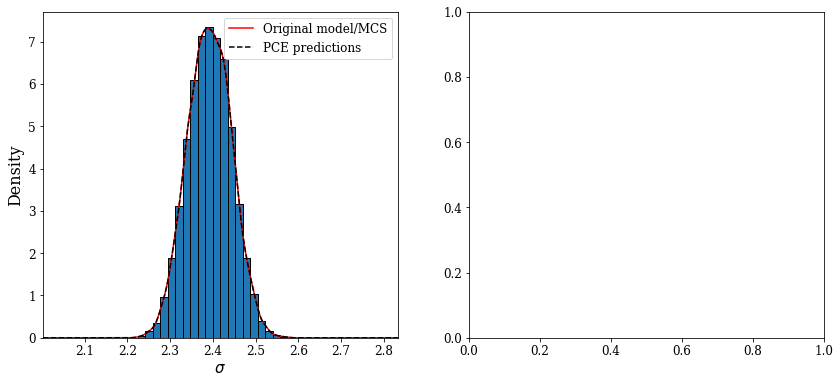

In [47]:
stretch = 1.1
# Try plotting as 3D
# Find the index of the stretch value in the def_array
def_array = pce_constructor.y('deformation')[0]
try:
    # Find index of float stretch in numpy array def_array
    idx = np.where(def_array == stretch)[0][0]
    pce = pce_dict[stretch]
except ValueError:
    raise ValueError(f"Stretch value {stretch} not found in the def_array")
except KeyError:
    raise ValueError(f"Stretch value {stretch} not found in the PCE dictionary")

pce_output = pce(*pce_constructor.x())
y = pce_constructor.y(study_output)[:, idx]
pce_output.shape, y.shape

stress_idx = 0
pce_output = pce_output[stress_idx, :]
y = y[:, stress_idx]

# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(14, 6))
x_min = 0.9*np.min(y)
x_max = 1.1*np.max(y)
x = np.linspace(x_min, x_max, 1000)
n_bins = 20

# Histogram of the original model/MCS output
axs[0].hist(y, bins=n_bins, density=True, edgecolor='black')
axs[0].set_xlim(x_min, x_max)
#axs[0].set_ylim(0, 90)
kde = gaussian_kde(y)
axs[0].plot(x, kde(x), label="Original model/MCS", color="red")
kde = gaussian_kde(pce_output)
axs[0].plot(x, kde(x), label="PCE predictions", color="black", linestyle="--")
axs[0].set_xlabel("$\sigma$", fontsize=15)
axs[0].set_ylabel("Density", fontsize=16)
axs[0].legend()

# # Histogram of the PCE predictions
# axs[1].hist(pce_output, bins=n_bins, density=True, edgecolor='black')
# axs[1].set_xlim(x_min, x_max)
# #axs[1].set_ylim(0, 90)
# kde = gaussian_kde(pce_output)
# axs[1].plot(x, kde(x), label="PCE predictions", color="red")
# axs[1].set_xlabel("$\sigma$", fontsize=15)
# axs[1].set_ylabel("Density", fontsize=16)
# axs[1].legend()

# plt.tight_layout()
# plt.show()

# 1. NEO-HOOKEAN

In [18]:
results_dir_NH = 'NH'

df_results_NH = pd.read_csv(f'sim/{results_dir_NH}/results.csv')
with open(f'sim/{results_dir_NH}/study_props_info.csv', 'r') as file:
    rnd_inputs_NH = json.load(file)

In [19]:
len(df_results_NH), df_results_NH.head()

(10000,
                                             s_normal  \
 0  [4.44089210e-16 1.80439380e-01 3.61250499e-01 ...   
 1  [2.22044605e-16 1.44055807e-01 2.88408396e-01 ...   
 2  [2.22044605e-16 1.59490157e-01 3.19308895e-01 ...   
 3  [2.22044605e-16 1.93159693e-01 3.86717333e-01 ...   
 4  [4.44089210e-16 1.83200519e-01 3.66778467e-01 ...   
 
                            s_shear  \
 0  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]   
 1  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]   
 2  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]   
 3  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]   
 4  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]   
 
                                            sef_array  \
 0  [0.         0.00441239 0.01728591 0.03812466 0...   
 1  [0.         0.00352268 0.0138004  0.03043725 0...   
 2  [0.         0.00390011 0.015279   0.03369834 0...   
 3  [0.         0.00472345 0.0185045  0.04081231 0...   
 4  [0.         0.00447991 0.01755043 0.03870805 0...   
 
                                            def_array  \
 0  [1.    

In [20]:
pce_constructor_NH = PCEConstructor(df_results_NH, rnd_inputs_NH)

## 1.1 NH 1
- fixed stretch: $\lambda = 1.3$
- output: $\Psi $

In [21]:
pce_NH_sef_d3_nf3_s5 = pce_constructor_NH.get_pce('sef_array', 3, 3, seed=5)
pce_NH_sef_d1_nf3_s5 = pce_constructor_NH.get_pce('sef_array', 1, 3, seed=5)
def_array = pce_constructor_NH.y('def_array')[0]

pce_NH_sef_d1_nf3_s5

[[0.78733443 0.98281385 0.71561927]] (1, 3)
[[0.78733443 0.98281385 0.71561927]] (1, 3)


{1.0: polynomial(0.0),
 1.03333333: polynomial(0.0032616288241976857*q0+1.6305416267181627e-08),
 1.06666667: polynomial(0.012777806804352775*q0-2.5828239295574984e-08),
 1.1: polynomial(0.028181815591559477*q0+2.4559822717207247e-09),
 1.13333333: polynomial(0.049150327895695047*q0-3.346897453626596e-09),
 1.16666667: polynomial(0.0753968094867595*q0+1.259319887259025e-08),
 1.2: polynomial(0.1066666850285181*q0-1.4687311908345713e-08),
 1.23333333: polynomial(0.14273276640308866*q0-2.9571546766860024e-08),
 1.26666667: polynomial(0.18339178612714926*q0+2.3178340552432175e-08),
 1.3: polynomial(0.22846152993600724*q0+4.330982295019936e-09)}

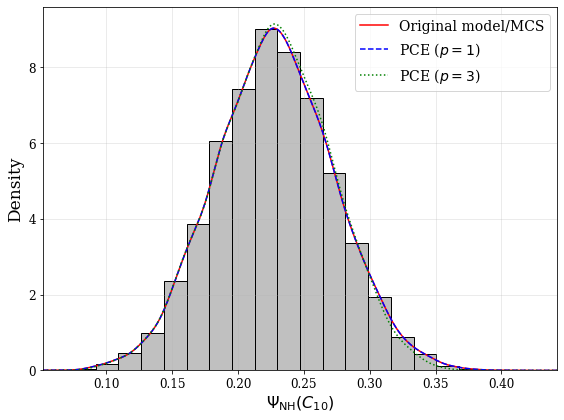

In [13]:
stretch = 1.3
# Try plotting as 3D
# Find the index of the stretch value in the def_array
def_array = pce_constructor_NH.y('def_array')[0]
try:
    # Find index of float stretch in numpy array def_array
    idx = np.where(def_array == stretch)[0][0]
    pced3 = pce_NH_sef_d3_nf3_s5[stretch]
    pced1 = pce_NH_sef_d1_nf3_s5[stretch]
except ValueError:
    raise ValueError(f"Stretch value {stretch} not found in the def_array")
except KeyError:
    raise ValueError(f"Stretch value {stretch} not found in the PCE dictionary")

pce_output_d1 = pced1(*pce_constructor_NH.x())
pce_output_d3 = pced3(*pce_constructor_NH.x())
y = pce_constructor_NH.y('sef_array')[:, idx]

# Create subplots
fig, axs = plt.subplots(1, 1, figsize=(8, 6))
x_min = 0.9*np.min(y)
x_max = 1.1*np.max(y)
x = np.linspace(x_min, x_max, 1000)
n_bins = 20

# Histogram of the original model/MCS output
axs.grid(True,alpha=0.3)
axs.hist(y, bins=n_bins, density=True, edgecolor='black', alpha=1, color="silver")
axs.set_xlim(x_min, x_max)
#axs.set_ylim(0, 90)
kde_real = gaussian_kde(y)
axs.plot(x, kde_real(x), label="Original model/MCS", color="red", alpha=1.)
kde_d1 = gaussian_kde(pce_output_d1)
axs.plot(x, kde_d1(x), label="PCE ($p=1$)", color="blue", linestyle="--")
kde_d3 = gaussian_kde(pce_output_d3)
axs.plot(x, kde_d3(x), label="PCE ($p=3$)", color="green", linestyle=":")
axs.set_xlabel("$\Psi_{\mathrm{NH}}(C_{10})$", fontsize=16)
axs.set_ylabel("Density", fontsize=17)
axs.legend(fontsize=14)

# Histogram of the PCE predictions
# axs[1].grid(True,alpha=0.3)
# axs[1].hist(pce_output, bins=n_bins, density=True, edgecolor='black')
# axs[1].set_xlim(x_min, x_max)
# #axs[1].set_ylim(0, 90)
# kde = gaussian_kde(pce_output)
# axs[1].plot(x, kde(x), label="PCE predictions", color="red")
# axs[1].set_xlabel("$\Psi(C_{10})$", fontsize=15)
# axs[1].set_ylabel("Density", fontsize=16)
# axs[1].legend()

plt.savefig('figures/NH_1_1.pdf', bbox_inches='tight')
plt.tight_layout()
plt.show()

## 1.2 NH 2
- fixed stretch: $\lambda = 1.3$
- output: $\sigma_{xx} $

In [14]:
pce_NH_sxx_d3_nf3_s5 = pce_constructor_NH.get_pce('s_normal', 4, 3, seed=0)
pce_NH_sxx_d1_nf3_s5 = pce_constructor_NH.get_pce('s_normal', 1, 3, seed=0)
def_array = pce_constructor_NH.y('def_array')[0]

pce_NH_sxx_d1_nf3_s5

[[0.7520947  1.51888492 0.88061658]]
[[0.7520947  1.51888492 0.88061658]]


{1.0: polynomial(3.083253619645832e-16*q0-2.7846205932925683e-17),
 1.03333333: polynomial(0.133381122795173*q0+2.744685867472896e-10),
 1.06666667: polynomial(0.26703703723125133*q0-2.14423256927887e-10),
 1.1: polynomial(0.4012121218628796*q0-6.410501574016791e-10),
 1.13333333: polynomial(0.5361220039124202*q0+3.500274514678381e-10),
 1.16666667: polynomial(0.6719576677804715*q0+3.188689534638911e-09),
 1.2: polynomial(0.80888888396272*q0+4.19215429037223e-09),
 1.23333333: polynomial(0.9470670617283513*q0+4.068170911253333e-09),
 1.26666667: polynomial(1.08662767368515*q0+5.498300703621339e-09),
 1.3: polynomial(1.227692307896969*q0+3.227176303965962e-10)}

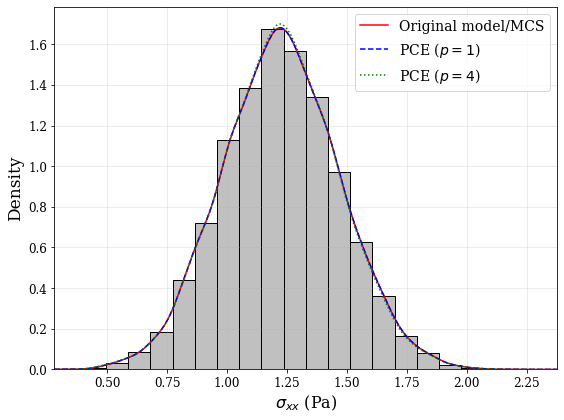

In [54]:
stretch = 1.3
# Try plotting as 3D
# Find the index of the stretch value in the def_array
try:
    # Find index of float stretch in numpy array def_array
    idx = np.where(def_array == stretch)[0][0]
    pced3 = pce_NH_sxx_d3_nf3_s5[stretch]
    pced1 = pce_NH_sxx_d1_nf3_s5[stretch]
except ValueError:
    raise ValueError(f"Stretch value {stretch} not found in the def_array")
except KeyError:
    raise ValueError(f"Stretch value {stretch} not found in the PCE dictionary")

pce_output_d1 = pced1(*pce_constructor_NH.x())
pce_output_d3 = pced3(*pce_constructor_NH.x())
y = pce_constructor_NH.y('s_normal')[:, idx]

# Create subplots
fig, axs = plt.subplots(1, 1, figsize=(8, 6))
x_min = 0.9*np.min(y)
x_max = 1.1*np.max(y)
x = np.linspace(x_min, x_max, 1000)
n_bins = 20

# Histogram of the original model/MCS output
axs.grid(True,alpha=0.3)
axs.hist(y, bins=n_bins, density=True, edgecolor='black', alpha=1, color="silver")
axs.set_xlim(x_min, x_max)
#axs.set_ylim(0, 90)
kde_real = gaussian_kde(y)
axs.plot(x, kde_real(x), label="Original model/MCS", color="red", alpha=1.)
kde_d1 = gaussian_kde(pce_output_d1)
axs.plot(x, kde_d1(x), label="PCE ($p=1$)", color="blue", linestyle="--")
kde_d3 = gaussian_kde(pce_output_d3)
axs.plot(x, kde_d3(x), label="PCE ($p=4$)", color="green", linestyle=":")
axs.set_xlabel("$\sigma_{xx}$ (Pa)", fontsize=16)
axs.set_ylabel("Density", fontsize=17)
axs.legend(fontsize=14)

plt.savefig('figures/NH_1_2.pdf', bbox_inches='tight')
plt.tight_layout()
plt.show()

## 1.3 NH 3

- 2D and 3D plots for all increments

In [16]:
pce_NH_3D = pce_constructor_NH.get_pce('sef_array', 1, 10, seed=0)
def_array = pce_constructor_NH.y('def_array')[0]

pce_NH_3D

[[0.7520947  1.51888492 0.88061658 0.74367018 1.17242961 0.73565175
  1.05151919 1.0822588  0.84394403 1.23560625]]


{1.0: polynomial(0.0),
 1.03333333: polynomial(0.003261646624529851*q0+2.2535552039910922e-09),
 1.06666667: polynomial(0.012777777744911883*q0-9.670944947637317e-10),
 1.1: polynomial(0.028181816986980038*q0+2.0149789579926303e-09),
 1.13333333: polynomial(0.04915033077720332*q0-5.868865844693705e-09),
 1.16666667: polynomial(0.07539682624988425*q0-9.974282094704634e-10),
 1.2: polynomial(0.10666666809330091*q0-1.4291401811972193e-09),
 1.23333333: polynomial(0.14273273075292459*q0+2.1451020681961808e-09),
 1.26666667: polynomial(0.1833918149080198*q0-3.098778539323277e-09),
 1.3: polynomial(0.22846154241393923*q0-4.882340420842013e-09)}

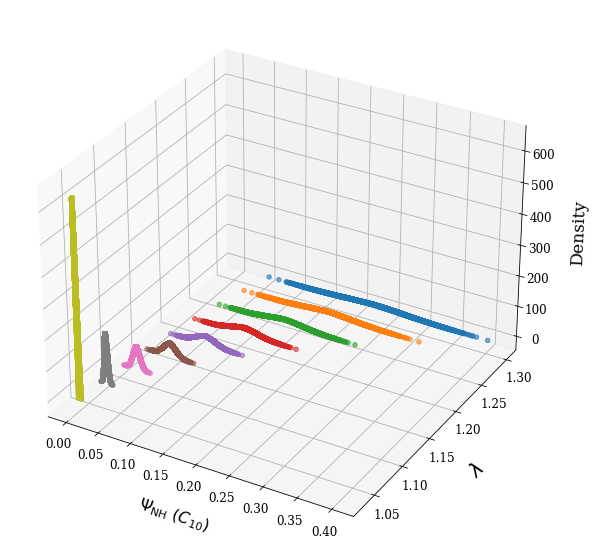

In [36]:
from mpl_toolkits.mplot3d import Axes3D

# Get all stretches from def_array
stretches = def_array

# Create subplots
fig = plt.figure(figsize=(14, 10), facecolor=None)
ax = fig.add_subplot(111, projection='3d')
# Set ax background color to white
# ax.set_facecolor('white')
ax.grid(True,alpha=0.3)
x = np.linspace(0, 0.4, 10000)

# Loop through each stretch and plot the data
for stretch in stretches[::-1]:
    if stretch > 1.0:
        try:
            # Find index of float stretch in numpy array def_array
            idx = np.where(def_array == stretch)[0][0]
            pce = pce_NH_3D[stretch]
        except ValueError:
            raise ValueError(f"Stretch value {stretch} not found in the def_array")
        except KeyError:
            raise ValueError(f"Stretch value {stretch} not found in the PCE dictionary")

        pce_output = pce(*pce_constructor_NH.x())
        y = pce_constructor_NH.y('sef_array')[:, idx]

        # Plot the data with sef on the x-axis, stretch on the y-axis, and density on the z-axis
        ax.scatter(pce_output, stretch, gaussian_kde(y)(y), alpha=0.6)

ax.set_xlabel('$\Psi_{\mathrm{NH}}$ $(C_{10})$', fontsize=16, labelpad=15)
ax.set_ylabel('$\lambda$', fontsize=20, labelpad=15)
ax.set_zlabel('Density', fontsize=17, labelpad=15)
# ax.set_zscale('log')
plt.savefig('figures/NH_1_3_1.pdf', bbox_inches='tight')
plt.show()


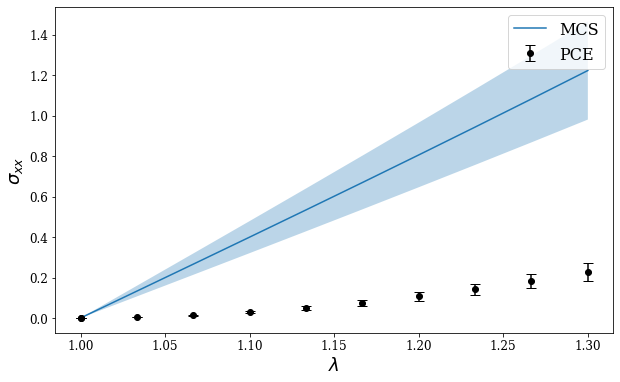

In [61]:
import seaborn as sns

# For each stretch value, plot the expected value of the PCE output and standard deviation
expected_values = []
std_devs = []
for stretch in stretches:
    try:
        # Find index of float stretch in numpy array def_array
        idx = np.where(def_array == stretch)[0][0]
        pce = pce_NH_3D[stretch]
    except ValueError:
        raise ValueError(f"Stretch value {stretch} not found in the def_array")
    except KeyError:
        raise ValueError(f"Stretch value {stretch} not found in the PCE dictionary")

    pce_output = pce(*pce_constructor_NH.x())
    y = pce_constructor_NH.y('s_normal')[:, idx]

    # Calculate the expected value and standard deviation of the PCE output
    expected_values.append(np.mean(pce_output))
    std_devs.append(np.std(pce_output))

expected_values, std_devs

# Plot the expected value of the PCE output and standard deviation as box plots, in the same plot, for each stretch value
fig, ax = plt.subplots(figsize=(10, 6))
for i, stretch in enumerate(stretches):
    if i == 0:
        ax.errorbar(stretch, expected_values[i], yerr=std_devs[i], fmt='o', color='black', capsize=5, label=f'PCE')
    ax.errorbar(stretch, expected_values[i], yerr=std_devs[i], fmt='o', color='black', capsize=5)
sef_curves = pce_constructor_NH.y('s_normal')
# Calculate the expected value and standard deviation of the true sef curves
expected_values = np.mean(sef_curves, axis=0)
std_devs = np.std(sef_curves, axis=0)

sns.lineplot(x=stretches, y=expected_values, ax=ax, label='MCS')
ax.fill_between(stretches, expected_values - std_devs, expected_values + std_devs, alpha=0.3)
ax.set_xlabel('$\lambda$', fontsize=18)
ax.set_ylabel('$\sigma_{xx}$', fontsize=18)
ax.legend(fontsize=16)
#ax.set_yscale('log')
#plt.savefig('figures/NH_1_4_1.pdf', bbox_inches='tight')



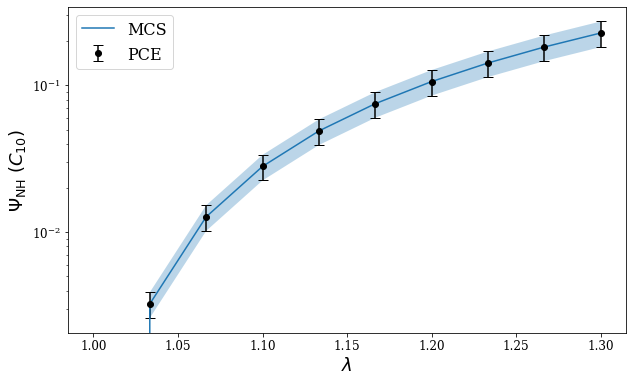

In [35]:
# Plot the expected value of the PCE output and standard deviation as box plots, in the same plot, for each stretch value
fig, ax = plt.subplots(figsize=(10, 6))
for i, stretch in enumerate(stretches):
    if i == 0:
        ax.errorbar(stretch, expected_values[i], yerr=std_devs[i], fmt='o', color='black', capsize=5, label=f'PCE')
    ax.errorbar(stretch, expected_values[i], yerr=std_devs[i], fmt='o', color='black', capsize=5)
sef_curves = pce_constructor_NH.y('sef_array')
# Calculate the expected value and standard deviation of the true sef curves
expected_values = np.mean(sef_curves, axis=0)
std_devs = np.std(sef_curves, axis=0)

sns.lineplot(x=stretches, y=expected_values, ax=ax, label='MCS')
ax.fill_between(stretches, expected_values - std_devs, expected_values + std_devs, alpha=0.3)
ax.set_xlabel('$\lambda$', fontsize=18)
ax.set_ylabel('$\Psi_{\mathrm{NH}}$ $(C_{10})$', fontsize=18)
ax.set_yscale('log')
ax.legend(fontsize=16)
plt.savefig('figures/NH_1_4_2.pdf', bbox_inches='tight')

# 2. MOONEY-RIVLIN

In [4]:
results_dir_MR = 'MR_new'

df_results_MR = pd.read_csv(f'sim/{results_dir_MR}/results.csv')
with open(f'sim/{results_dir_MR}/study_props_info.csv', 'r') as file:
    rnd_inputs_MR = json.load(file)

In [5]:
len(df_results_MR), df_results_MR.head()

(100,
                                               stress  \
 0  [[ 8.88178420e-16  8.88178420e-16  8.88178420e...   
 1  [[ 8.88178420e-16  8.88178420e-16  8.88178420e...   
 2  [[ 4.44089210e-16  4.44089210e-16  4.44089210e...   
 3  [[ 8.88178420e-16  8.88178420e-16  8.88178420e...   
 4  [[ 8.88178420e-16  8.88178420e-16  8.88178420e...   
 
                                                  sef  \
 0  [0.         0.0008401  0.00332625 0.00740912 0...   
 1  [0.         0.0007931  0.00313809 0.00698541 0...   
 2  [0.         0.0006642  0.00263116 0.00586378 0...   
 3  [0.         0.00083946 0.00332474 0.00740801 0...   
 4  [0.         0.00091671 0.00362848 0.00807994 0...   
 
                                          deformation  \
 0  [1.         1.01111111 1.02222222 1.03333333 1...   
 1  [1.         1.01111111 1.02222222 1.03333333 1...   
 2  [1.         1.01111111 1.02222222 1.03333333 1...   
 3  [1.         1.01111111 1.02222222 1.03333333 1...   
 4  [1.         1.011

In [6]:
pce_constructor_MR = PCEConstructor(df_results_MR, rnd_inputs_MR)

/home/lpacheco/.local/lib/python3.6/site-packages/ipykernel_launcher.py:11: DeprecationWarning: string or file could not be read to its end due to unmatched data; this will raise a ValueError in the future.
  # This is added back by InteractiveShellApp.init_path()


## 2.1 MR 1
- fixed stretch: $\lambda = 1.3$
- output: $\Psi $

In [8]:
pce_MR_sef_d3_nf3_s5 = pce_constructor_MR.get_pce('sef', 3, 3, seed=3)
pce_MR_sef_d1_nf3_s5 = pce_constructor_MR.get_pce('sef', 1, 3, seed=3)
def_array = pce_constructor_MR.y('deformation')[0]

pce_MR_sef_d1_nf3_s5

KeyError: 'def_array'

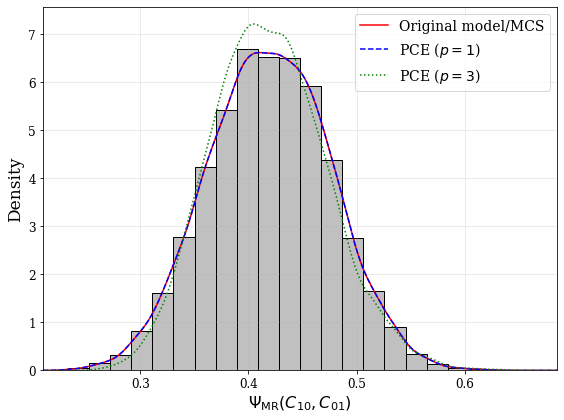

In [50]:
stretch = 1.3
# Try plotting as 3D
# Find the index of the stretch value in the def_array
def_array = pce_constructor_MR.y('def_array')[0]
try:
    # Find index of float stretch in numpy array def_array
    idx = np.where(def_array == stretch)[0][0]
    pced3 = pce_MR_sef_d3_nf3_s5[stretch]
    pced1 = pce_MR_sef_d1_nf3_s5[stretch]
except ValueError:
    raise ValueError(f"Stretch value {stretch} not found in the def_array")
except KeyError:
    raise ValueError(f"Stretch value {stretch} not found in the PCE dictionary")

pce_output_d1 = pced1(*pce_constructor_MR.x())
pce_output_d3 = pced3(*pce_constructor_MR.x())
y = pce_constructor_MR.y('sef_array')[:, idx]

# Create subplots
fig, axs = plt.subplots(1, 1, figsize=(8, 6))
x_min = 0.9*np.min(y)
x_max = 1.1*np.max(y)
x = np.linspace(x_min, x_max, 1000)
n_bins = 20

# Histogram of the original model/MCS output
axs.grid(True,alpha=0.3)
axs.hist(y, bins=n_bins, density=True, edgecolor='black', alpha=1, color="silver")
axs.set_xlim(x_min, x_max)
#axs.set_ylim(0, 90)
kde_real = gaussian_kde(y)
axs.plot(x, kde_real(x), label="Original model/MCS", color="red", alpha=1.)
kde_d1 = gaussian_kde(pce_output_d1)
axs.plot(x, kde_d1(x), label="PCE ($p=1$)", color="blue", linestyle="--")
kde_d3 = gaussian_kde(pce_output_d3)
axs.plot(x, kde_d3(x), label="PCE ($p=3$)", color="green", linestyle=":")
axs.set_xlabel("$\Psi_{\mathrm{MR}}(C_{10},C_{01})$", fontsize=16)
axs.set_ylabel("Density", fontsize=17)
axs.legend(fontsize=14)

# Histogram of the PCE predictions
# axs[1].grid(True,alpha=0.3)
# axs[1].hist(pce_output, bins=n_bins, density=True, edgecolor='black')
# axs[1].set_xlim(x_min, x_max)
# #axs[1].set_ylim(0, 90)
# kde = gaussian_kde(pce_output)
# axs[1].plot(x, kde(x), label="PCE predictions", color="red")
# axs[1].set_xlabel("$\Psi(C_{10})$", fontsize=15)
# axs[1].set_ylabel("Density", fontsize=16)
# axs[1].legend()

plt.savefig('figures/MR_1_1.pdf', bbox_inches='tight')
plt.tight_layout()
plt.show()

## 2.2 MR 2
- fixed stretch: $\lambda = 1.3$
- output: $\sigma_{xx} $

In [52]:
pce_MR_sxx_d3_nf3_s5 = pce_constructor_MR.get_pce('s_normal', 4, 3, seed=0)
pce_MR_sxx_d1_nf3_s5 = pce_constructor_MR.get_pce('s_normal', 1, 3, seed=0)
def_array = pce_constructor_MR.y('def_array')[0]

pce_MR_sxx_d1_nf3_s5

[[0.7520947  1.51888492 0.88061658]
 [0.75579013 1.29750457 0.90756567]]
[[0.7520947  1.51888492 0.88061658]
 [0.75579013 1.29750457 0.90756567]]


{1.0: polynomial(6.0620434255829575e-15*q1-3.703499569395548e-15*q0-1.3521609826764884e-15),
 1.03333333: polynomial(0.1290784964592297*q1+0.1333811302328256*q0+2.1168292674289546e-09),
 1.06666667: polynomial(0.250347226915425*q1+0.2670370344497966*q0-1.756606249347925e-09),
 1.1: polynomial(0.36473829174507977*q1+0.4012121220917376*q0-9.307393744606429e-10),
 1.13333333: polynomial(0.4730488368289759*q1+0.5361219965444693*q0-1.5587597879118675e-09),
 1.16666667: polynomial(0.5759637997084808*q1+0.671957615440606*q0-1.8897985620824898e-08),
 1.2: polynomial(0.6740741473884667*q1+0.8088888305049732*q0-1.056029219625998e-08),
 1.23333333: polynomial(0.7678923116192266*q1+0.9470669964623463*q0-1.9491529723580925e-08),
 1.26666667: polynomial(0.857864007587003*q1+1.0866276492728422*q0-1.6707828232043198e-08),
 1.3: polynomial(0.9443787104488338*q1+1.2276923028551738*q0-3.6632743505293774e-09)}

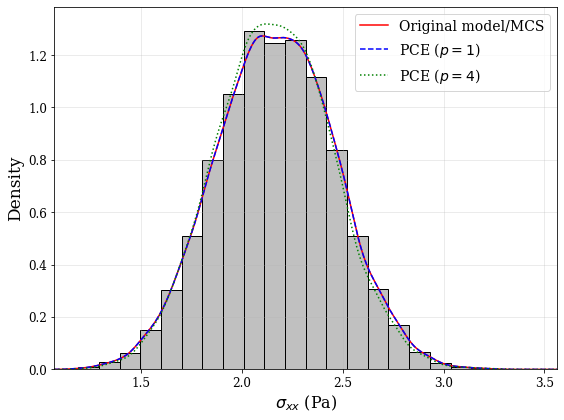

In [55]:
stretch = 1.3
# Try plotting as 3D
# Find the index of the stretch value in the def_array
try:
    # Find index of float stretch in numpy array def_array
    idx = np.where(def_array == stretch)[0][0]
    pced3 = pce_MR_sxx_d3_nf3_s5[stretch]
    pced1 = pce_MR_sxx_d1_nf3_s5[stretch]
except ValueError:
    raise ValueError(f"Stretch value {stretch} not found in the def_array")
except KeyError:
    raise ValueError(f"Stretch value {stretch} not found in the PCE dictionary")

pce_output_d1 = pced1(*pce_constructor_MR.x())
pce_output_d3 = pced3(*pce_constructor_MR.x())
y = pce_constructor_MR.y('s_normal')[:, idx]

# Create subplots
fig, axs = plt.subplots(1, 1, figsize=(8, 6))
x_min = 0.9*np.min(y)
x_max = 1.1*np.max(y)
x = np.linspace(x_min, x_max, 1000)
n_bins = 20

# Histogram of the original model/MCS output
axs.grid(True,alpha=0.3)
axs.hist(y, bins=n_bins, density=True, edgecolor='black', alpha=1, color="silver")
axs.set_xlim(x_min, x_max)
#axs.set_ylim(0, 90)
kde_real = gaussian_kde(y)
axs.plot(x, kde_real(x), label="Original model/MCS", color="red", alpha=1.)
kde_d1 = gaussian_kde(pce_output_d1)
axs.plot(x, kde_d1(x), label="PCE ($p=1$)", color="blue", linestyle="--")
kde_d3 = gaussian_kde(pce_output_d3)
axs.plot(x, kde_d3(x), label="PCE ($p=4$)", color="green", linestyle=":")
axs.set_xlabel("$\sigma_{xx}$ (Pa)", fontsize=16)
axs.set_ylabel("Density", fontsize=17)
axs.legend(fontsize=14)

plt.savefig('figures/MR_1_2.pdf', bbox_inches='tight')
plt.tight_layout()
plt.show()

## 2.3 MR 3

- 2D and 3D plots for all increments

In [56]:
pce_MR_3D = pce_constructor_MR.get_pce('sef_array', 1, 10, seed=0)
def_array = pce_constructor_MR.y('def_array')[0]

pce_MR_3D

[[0.7520947  1.51888492 0.88061658 0.74367018 1.17242961 0.73565175
  1.05151919 1.0822588  0.84394403 1.23560625]
 [0.75579013 1.29750457 0.90756567 0.8675032  0.70798566 1.12607183
  1.26187039 1.13753997 1.05981631 0.9753713 ]]


{1.0: polynomial(0.0),
 1.03333333: polynomial(0.003191120751284902*q1+0.0032616431510235884*q0+5.039950923615977e-09),
 1.06666667: polynomial(0.012239586744139231*q1+0.012777776165121671*q0-1.4030622063482268e-09),
 1.1: polynomial(0.026446282834396626*q1+0.028181817963523904*q0-2.0487004419311727e-09),
 1.13333333: polynomial(0.04521338865670389*q1+0.04915032499388412*q0-7.610044497341484e-09),
 1.16666667: polynomial(0.06802720744652488*q1+0.07539682941531808*q0+6.789691031627854e-11),
 1.2: polynomial(0.09444445259848759*q1+0.10666666434336892*q0-5.1192334815652885e-09),
 1.23333333: polynomial(0.12408083441762452*q1+0.1427327374575265*q0-2.11574543995674e-09),
 1.26666667: polynomial(0.15660203147862847*q1+0.18339181351015202*q0-7.798029999506184e-10),
 1.3: polynomial(0.1917159790641*q1+0.2284615350451262*q0+2.7447474293396112e-09)}

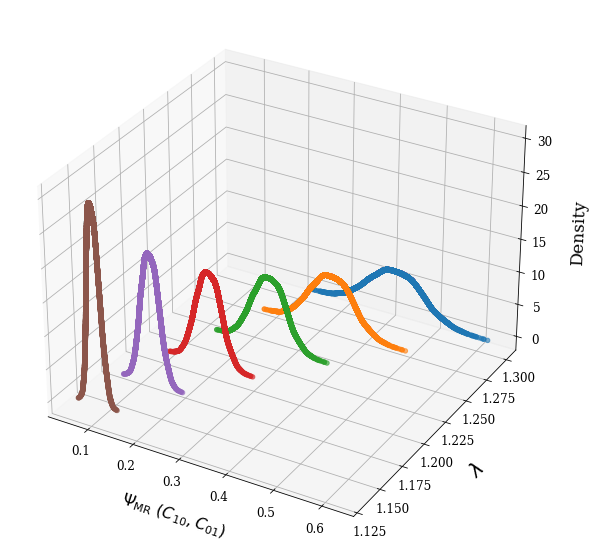

In [58]:
from mpl_toolkits.mplot3d import Axes3D

# Get all stretches from def_array
stretches = def_array

# Create subplots
fig = plt.figure(figsize=(14, 10), facecolor=None)
ax = fig.add_subplot(111, projection='3d')
# Set ax background color to white
# ax.set_facecolor('white')
ax.grid(True,alpha=0.3)
x = np.linspace(0, 0.4, 10000)

# Loop through each stretch and plot the data
for stretch in stretches[::-1]:
    if stretch > 1.1:
        try:
            # Find index of float stretch in numpy array def_array
            idx = np.where(def_array == stretch)[0][0]
            pce = pce_MR_3D[stretch]
        except ValueError:
            raise ValueError(f"Stretch value {stretch} not found in the def_array")
        except KeyError:
            raise ValueError(f"Stretch value {stretch} not found in the PCE dictionary")

        pce_output = pce(*pce_constructor_MR.x())
        y = pce_constructor_MR.y('sef_array')[:, idx]

        # Plot the data with sef on the x-axis, stretch on the y-axis, and density on the z-axis
        ax.scatter(pce_output, stretch, gaussian_kde(y)(y), alpha=0.6)

ax.set_xlabel('$\Psi_{\mathrm{MR}}$ $(C_{10},C_{01})$', fontsize=16, labelpad=15)
ax.set_ylabel('$\lambda$', fontsize=20, labelpad=15)
ax.set_zlabel('Density', fontsize=17, labelpad=15)
# ax.set_zscale('log')
plt.savefig('figures/MR_1_3_2.pdf', bbox_inches='tight')
plt.show()


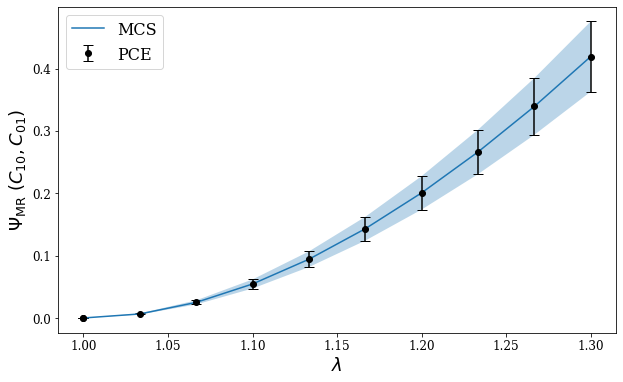

In [59]:
import seaborn as sns

# For each stretch value, plot the expected value of the PCE output and standard deviation
expected_values = []
std_devs = []
for stretch in stretches:
    try:
        # Find index of float stretch in numpy array def_array
        idx = np.where(def_array == stretch)[0][0]
        pce = pce_MR_3D[stretch]
    except ValueError:
        raise ValueError(f"Stretch value {stretch} not found in the def_array")
    except KeyError:
        raise ValueError(f"Stretch value {stretch} not found in the PCE dictionary")

    pce_output = pce(*pce_constructor_MR.x())
    y = pce_constructor_MR.y('sef_array')[:, idx]

    # Calculate the expected value and standard deviation of the PCE output
    expected_values.append(np.mean(pce_output))
    std_devs.append(np.std(pce_output))

expected_values, std_devs

# Plot the expected value of the PCE output and standard deviation as box plots, in the same plot, for each stretch value
fig, ax = plt.subplots(figsize=(10, 6))
for i, stretch in enumerate(stretches):
    if i == 0:
        ax.errorbar(stretch, expected_values[i], yerr=std_devs[i], fmt='o', color='black', capsize=5, label=f'PCE')
    ax.errorbar(stretch, expected_values[i], yerr=std_devs[i], fmt='o', color='black', capsize=5)
sef_curves = pce_constructor_MR.y('sef_array')
# Calculate the expected value and standard deviation of the true sef curves
expected_values = np.mean(sef_curves, axis=0)
std_devs = np.std(sef_curves, axis=0)

sns.lineplot(x=stretches, y=expected_values, ax=ax, label='MCS')
ax.fill_between(stretches, expected_values - std_devs, expected_values + std_devs, alpha=0.3)
ax.set_xlabel('$\lambda$', fontsize=18)
ax.set_ylabel('$\Psi_{\mathrm{MR}}$ $(C_{10},C_{01})$', fontsize=18)
ax.legend(fontsize=16)
#ax.set_yscale('log')
plt.savefig('figures/MR_1_4_1.pdf', bbox_inches='tight')



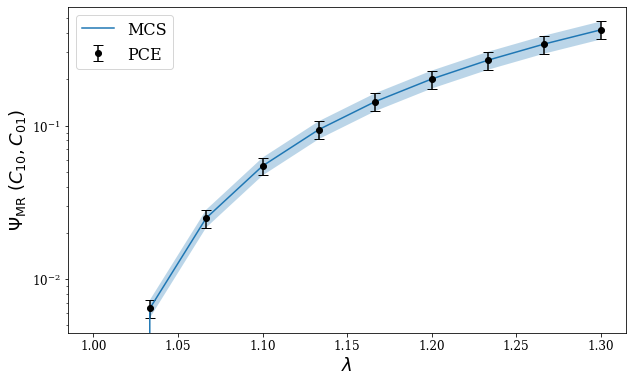

In [60]:
# Plot the expected value of the PCE output and standard deviation as box plots, in the same plot, for each stretch value
fig, ax = plt.subplots(figsize=(10, 6))
for i, stretch in enumerate(stretches):
    if i == 0:
        ax.errorbar(stretch, expected_values[i], yerr=std_devs[i], fmt='o', color='black', capsize=5, label=f'PCE')
    ax.errorbar(stretch, expected_values[i], yerr=std_devs[i], fmt='o', color='black', capsize=5)
sef_curves = pce_constructor_MR.y('sef_array')
# Calculate the expected value and standard deviation of the true sef curves
expected_values = np.mean(sef_curves, axis=0)
std_devs = np.std(sef_curves, axis=0)

sns.lineplot(x=stretches, y=expected_values, ax=ax, label='MCS')
ax.fill_between(stretches, expected_values - std_devs, expected_values + std_devs, alpha=0.3)
ax.set_xlabel('$\lambda$', fontsize=18)
ax.set_ylabel('$\Psi_{\mathrm{MR}}$ $(C_{10},C_{01})$', fontsize=18)
ax.set_yscale('log')
ax.legend(fontsize=16)
plt.savefig('figures/MR_1_4_2.pdf', bbox_inches='tight')

# 3. FN

In [5]:
results_dir = 'FINAL'

# Load results data from pickle
with open(f'sim/{results_dir}/results.pkl', 'rb') as file:
    df_results = pickle.load(file)

# Load random inputs from csv
with open(f'sim/{results_dir}/study_props_info.csv', 'r') as file:
    rnd_inputs = json.load(file)

In [6]:
# len(df_results)
df_results.head()

,stress,sef,deformation,time,C10,C01,CACTIN,R,R0C,ETA,BDISP
0,"[[4.440892098500626e-16, 0.0, 0.0, 0.0, 0.0, 0...","[0.0, 0.0012482774756932351, 0.004993109902781...","[0.0, 0.022222222222222223, 0.0444444444444444...","[0.0, 0.1111111111111111, 0.2222222222222222, ...",1.352810,1.174951,11.833718,0.087638,0.016224,0.516179,1.011283
1,"[[2.220446049250313e-16, 0.0, 0.0, 0.0, 0.0, 0...","[0.0, 0.0009947255536177572, 0.003978902214477...","[0.0, 0.022222222222222223, 0.0444444444444444...","[0.0, 0.1111111111111111, 0.2222222222222222, ...",1.080031,0.934288,10.178291,0.116290,0.014773,0.376196,1.004207
2,"[[4.440892098500626e-16, 0.0, 0.0, 0.0, 0.0, 0...","[0.0, 0.0012062799422444446, 0.004825119768986...","[0.0, 0.022222222222222223, 0.0444444444444444...","[0.0, 0.1111111111111111, 0.2222222222222222, ...",1.195748,1.246969,8.583514,0.091872,0.011107,0.526924,1.006608
3,"[[4.440892098500626e-16, 0.0, 0.0, 0.0, 0.0, 0...","[0.0, 0.0013155629998780833, 0.005262251999520...","[0.0, 0.022222222222222223, 0.0444444444444444...","[0.0, 0.1111111111111111, 0.2222222222222222, ...",1.448179,1.215836,10.018665,0.102507,0.010693,0.345133,0.986213
4,"[[2.220446049250313e-16, 0.0, 0.0, 0.0, 0.0, 0...","[0.0, 0.0010499394722843884, 0.004199757889143...","[0.0, 0.022222222222222223, 0.0444444444444444...","[0.0, 0.1111111111111111, 0.2222222222222222, ...",1.373512,0.752616,9.472285,0.090301,0.018664,0.446881,0.993616


In [7]:
pce_constructor = PCEConstructor(df_results, rnd_inputs)

## 3.1 FN 1
- fixed shear: $\gamma = 0.2$
- output: $\sigma_{ij}$

In [8]:
y_col = 'stress'
seed_id = 0
poly_degree = 3

pce_d2_s10 = pce_constructor.get_pce(y_col, 2, 10, seed=seed_id)
pce_d2_s100 = pce_constructor.get_pce(y_col, 2, 100, seed=seed_id)
pce_d3_s100 = pce_constructor.get_pce(y_col, 3, 100, seed=seed_id)
# def_array = pce_constructor.y('deformation')[0]


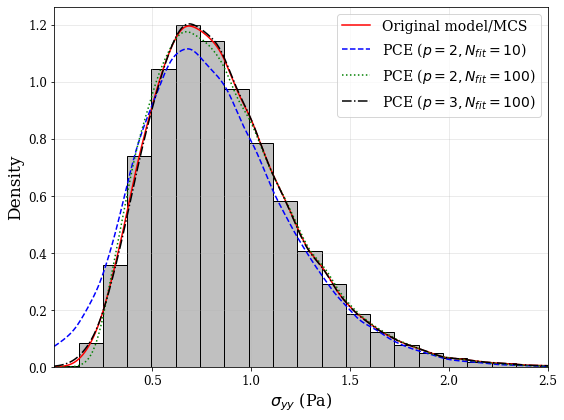

In [13]:
shear = 0.2
stress_idx = 1
# Try plotting as 3D
# Find the index of the shear value in the def_array
def_array = pce_constructor.y('deformation')[0]
try:
    # Find index of float shear in numpy array def_array
    idx = np.where(def_array == shear)[0][0]
    pce1 = pce_d2_s10[shear]
    pce2 = pce_d2_s100[shear]
    pce3 = pce_d3_s100[shear]
except ValueError:
    raise ValueError(f"shear value {shear} not found in the def_array")
except KeyError:
    raise ValueError(f"shear value {shear} not found in the PCE dictionary")

pce1_output = pce1(*pce_constructor.x())
pce2_output = pce2(*pce_constructor.x())
pce3_output = pce3(*pce_constructor.x())
y = pce_constructor.y(y_col)[:, idx]

pce1_output = pce1_output[stress_idx, :]
pce2_output = pce2_output[stress_idx, :]
pce3_output = pce3_output[stress_idx, :]
y = y[:, stress_idx]

# Create subplots
fig, axs = plt.subplots(1, 1, figsize=(8, 6))
x_min = 0.9*np.min(y)
x_max = 1.1*np.max(y)
x = np.linspace(x_min, x_max, 1000)
n_bins = 40

# Histogram of the original model/MCS output
axs.grid(True,alpha=0.3)
axs.hist(y, bins=n_bins, density=True, edgecolor='black', alpha=1, color="silver")
axs.set_xlim(x_min, x_max)
axs.set_xlim(x_min,2.5)
#axs.set_ylim(0, 90)
kde_real = gaussian_kde(y)
axs.plot(x, kde_real(x), label="Original model/MCS", color="red", alpha=1.)
kde1 = gaussian_kde(pce1_output)
axs.plot(x, kde1(x), label=f"PCE ($p={2}, N_{{fit}}=10$)", color="blue", linestyle="--")
kde2 = gaussian_kde(pce2_output)
axs.plot(x, kde2(x), label=f"PCE ($p={2}, N_{{fit}}=100$)", color="green", linestyle=":")
kde3 = gaussian_kde(pce3_output)
axs.plot(x, kde3(x), label=f"PCE ($p={3}, N_{{fit}}=100$)", color="black", linestyle="-.")
direction_list = ['xx', 'yy', 'zz', 'xy', 'xz', 'yz']
axs.set_xlabel(f"$\sigma_{{{direction_list[stress_idx]}}}$ (Pa)", fontsize=16)
axs.set_ylabel("Density", fontsize=17)
axs.legend(fontsize=14)

# Histogram of the PCE predictions
# axs[1].grid(True,alpha=0.3)
# axs[1].hist(pce_output, bins=n_bins, density=True, edgecolor='black')
# axs[1].set_xlim(x_min, x_max)
# #axs[1].set_ylim(0, 90)
# kde = gaussian_kde(pce_output)
# axs[1].plot(x, kde(x), label="PCE predictions", color="red")
# axs[1].set_xlabel("$\Psi(C_{10})$", fontsize=15)
# axs[1].set_ylabel("Density", fontsize=16)
# axs[1].legend()

plt.savefig('figures/AN_1_1.pdf', bbox_inches='tight')
plt.tight_layout()
plt.show()

In [24]:
y = pce_constructor.y(y_col)[:, :, 1]
expected_values = np.mean(y, axis=0)
std_devs = np.std(y, axis=0)
# y = y[:, stress_idx]
# stress_curves = pce_constructor.y('sef_array')
y.shape, expected_values.shape, std_devs.shape

((100000, 10), (10,), (10,))

In [28]:
pce_output.shape

(6, 100000)

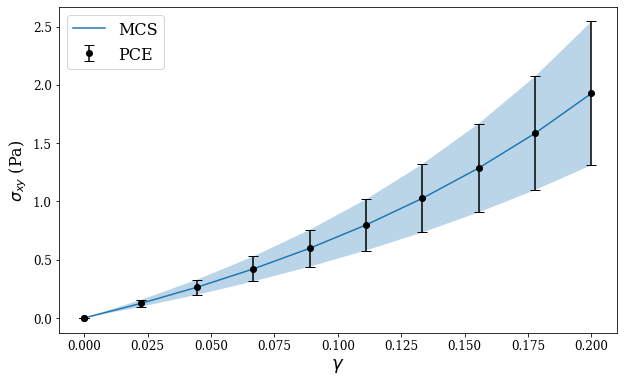

In [32]:
stress_idx = 3

# For each deformation value, plot the expected value of the PCE output and standard deviation
expected_values = []
std_devs = []
for deformation in def_array:
    try:
        # Find index of float stretch in numpy array def_array
        idx = np.where(def_array == deformation)[0][0]
        pce = pce_d3_s100[deformation]
    except ValueError:
        raise ValueError(f"Shear value {deformation} not found in def_array")
    except KeyError:
        raise ValueError(f"Shear value {deformation} not found in the PCE dictionary")

    pce_output = pce(*pce_constructor.x())[stress_idx, :]

    # Calculate the expected value and standard deviation of the PCE output
    expected_values.append(np.mean(pce_output))
    std_devs.append(np.std(pce_output))

expected_values, std_devs

# Plot the expected value of the PCE output and standard deviation as box plots, in the same plot, for each deformation value
fig, ax = plt.subplots(figsize=(10, 6))
for i, deformation in enumerate(def_array):
    if i == 0:
        ax.errorbar(deformation, expected_values[i], yerr=std_devs[i], fmt='o', color='black', 
                    capsize=5, label=f'PCE')
    ax.errorbar(deformation, expected_values[i], yerr=std_devs[i], fmt='o', color='black', 
                capsize=5)

stress_curves = pce_constructor.y(y_col)[:, :, stress_idx]
# Calculate the expected value and standard deviation of the true sef curves
expected_values = np.mean(stress_curves, axis=0)
std_devs = np.std(stress_curves, axis=0)

sns.lineplot(x=def_array, y=expected_values, ax=ax, label='MCS')
ax.fill_between(def_array, expected_values - std_devs, expected_values + std_devs, alpha=0.3)
ax.set_xlabel('$\gamma$', fontsize=18)
ax.set_ylabel(f"$\sigma_{{{direction_list[stress_idx]}}}$ (Pa)", fontsize=16)
ax.legend(fontsize=16)
# ax.set_yscale('log')
plt.savefig('figures/AN_2_2.pdf', bbox_inches='tight')


In [85]:
joint_dist = pce_constructor.get_joint_distribution()

# Get the Sobol indices for each input parameter
sobol_indices = cp.Sens_m(pced3, joint_dist)
sobol_indices.sum()

0.9777127991551745

In [ ]:
sobol_indices
cp.Sens_t

array([7.57282213e-06, 3.07111059e-06, 8.29977284e-02, 1.86320948e-02,
       8.76068423e-01, 3.90894662e-06])

(-0.1, 1.0)

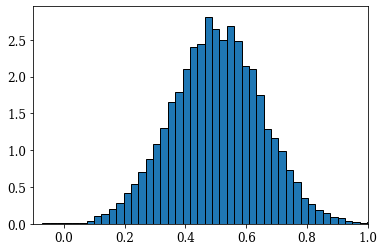

In [84]:
# histogram of a normal distribution with mean 0.5 and standard deviation 0.1
data = np.random.normal(0.5, 0.15, 10000)
plt.hist(data, bins=50, density=True, edgecolor='black')
plt.xlim(-0.1, 1)

-------------------------------------------------------------------------

-------------------------------------------------------------------------

-------------------------------------------------------------------------

-------------------------------------------------------------------------

In [5]:
import chaospy

normal = chaospy.Normal(0, 1)

hermite = chaospy.generate_expansion(2, normal)
hermite

polynomial([1.0, q0, q0**2-1.0])

In [8]:
hermite2 = chaospy.outer(hermite, hermite)
hermite2
# chaospy.E(hermite2, normal).round(15)

polynomial([[1.0, q0, q0**2-1.0],
            [q0, q0**2, q0**3-q0],
            [q0**2-1.0, q0**3-q0, q0**4-2.0*q0**2+1.0]])

In [10]:
import numpy as np
import chaospy
import sklearn.linear_model

# Define random seed
np.random.seed(0)

# Define the joint distribution
joint_dist = chaospy.J(chaospy.Normal(0, 1), chaospy.Uniform(-1, 1))

# Generate polynomials using the joint distribution
polynomials = chaospy.generate_expansion(1, joint_dist)

# Define the collocation nodes (abscissas) with shape (D, K) = (n_rnd_inputs, n_samples)
abscissas = np.array([[-1, -1, 1, 1],  [-1, 1, -1, 1], [5, -0, -0, 0]])

# Define the model evaluations (evals) with shape (K, n) = (n_samples, n_outputs)
# Here we obtain 2 polynomials (n=2)
evals = np.array([[1, 2, 2, 4, 5, 6], [1, 2, 2, 4, 5, 6], [1, 2, 3, 4, 5, 6], [1, 2, 3, 4, 5, 6]])

# Fit the polynomial chaos expansion using linear regression
fitted_polynomials = chaospy.fit_regression(polynomials, abscissas, evals)

# Print the fitted polynomials
print(fitted_polynomials)

[2.7755575615628907e-17*q1+2.775557561562892e-17*q0+1.0
 5.5511151231257815e-17*q1+5.551115123125784e-17*q0+2.0
 2.498001805406602e-16*q1+0.5000000000000001*q0+2.4999999999999996
 1.1102230246251563e-16*q1+1.1102230246251568e-16*q0+4.0
 1.3877787807814457e-16*q1+1.3877787807814457e-16*q0+5.0
 1.6653345369377348e-16*q1+1.6653345369377348e-16*q0+6.0]


In [11]:
polynomials

polynomial([1.0, q1, q0])

In [39]:
def card(m, p):
    return np.math.factorial(m + p) / (np.math.factorial(m) * np.math.factorial(p))

card(7, 6)

1716.0

In [13]:
fitted_polynomials(0.2, 0.2)

array([1. , 2. , 2.6, 4. , 5. , 6. ])

In [ ]:
from concurrent.futures import ProcessPoolExecutor
import pandas as pd

# Function to run a single simulation
def run_single_simulation(iSample, mat_props_manager, simulation):
    print(f"Running simulation for sample {iSample}")
    mat_props = mat_props_manager.get_material_props(iSample)
    iResults = simulation.run_umat(mat_props)
    print(f"Simulation for sample {iSample} completed.")
    return pd.DataFrame([iResults])

# Parallelized code
# Create empty dataframe for results
df_results = pd.DataFrame()

# Specify the number of CPUs to use
num_cpus = 4  # Replace with the desired number of CPUs

# Use ProcessPoolExecutor for parallel execution
with ProcessPoolExecutor(max_workers=num_cpus) as executor:
    # Submit tasks for each sample
    futures = [executor.submit(run_single_simulation, iSample, self.mat_props_manager, self.simulation)
               for iSample in range(self.n_samples)]
    
    # Collect results as they complete
    for future in futures:
        df_results = pd.concat([df_results, future.result()], axis=0, ignore_index=True)

# Save results to csv
self.simulation.save_results(df_results, self.mat_props_manager.study_props)
print("Study completed.")

0


(array([6.95069748e-06, 3.47534874e-06, 1.39013950e-05, 1.39013950e-05,
        4.51795336e-05, 1.00785114e-04, 2.15471622e-04, 4.27467895e-04,
        8.20182303e-04, 1.63688926e-03, 2.93319434e-03, 4.96627335e-03,
        8.54588256e-03, 1.41689968e-02, 2.20823659e-02, 3.28038168e-02,
        4.78416508e-02, 6.67023684e-02, 9.08803696e-02, 1.18346051e-01,
        1.48654567e-01, 1.78907478e-01, 2.06960493e-01, 2.33435700e-01,
        2.53040142e-01, 2.64971014e-01, 2.64501842e-01, 2.56849124e-01,
        2.39465430e-01, 2.15846960e-01, 1.88058071e-01, 1.56720852e-01,
        1.26509645e-01, 9.91169461e-02, 7.44419701e-02, 5.33188004e-02,
        3.73078687e-02, 2.46541240e-02, 1.63306637e-02, 1.00298565e-02,
        6.10271239e-03, 3.52747897e-03, 1.98789948e-03, 1.06345672e-03,
        5.35203706e-04, 2.32848366e-04, 1.21637206e-04, 6.25562774e-05,
        2.43274412e-05, 1.39013950e-05]),
 array([ 1.97802146,  2.26576237,  2.55350328,  2.84124418,  3.12898509,
         3.416726  , 

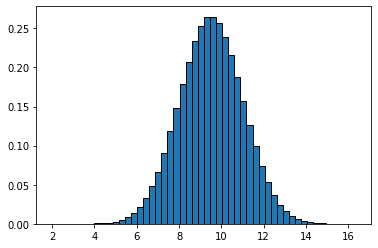

In [11]:
import numpy as np
import matplotlib.pyplot as plt

# hISTOGRAM OF NORMAL DISTRIBUTION
data = np.random.normal(9.5, 1.5, 1000000)
print(np.sum(data<0))
plt.hist(data, bins=50, density=True, edgecolor='black')

